# 1. The Istio Configurator
This class is responsible for applying different configurations to Istio.
We are primarily investigating the destination rules of the istio configurations. 
We define 11 actions that our agent could take on each of the services. 
In specific, the SockShop is made up of 14 services. Therefore, there will be in total 11 x 14 = 154 actions. These actions define our action space.

In [188]:
import yaml
import os

config_file = "destination-rules.yaml"
kubectl_apply_cmd = "kubectl apply -f "

class IstioConfig:
    def __init__(self, file_name):
        self.file_name = file_name
        with open(file_name, "r") as stream:
            docs = yaml.load_all(stream, Loader=yaml.FullLoader)
            self.docs = list(docs)
    
    # save to yaml file
    def save(self):
        with open(self.file_name, "w") as stream:
            yaml.dump_all(self.docs, stream)
    
    # apply to Istio cluster
    def apply(self):
        self.save()
        os.system(kubectl_apply_cmd + self.file_name + " > /dev/null")
        
    # reset to default config (does not save)
    def reset(self):
        for i in range(self.size()):
            ic.docs[i]["spec"]["trafficPolicy"]["connectionPool"]["http"] = {}
            ic.docs[i]["spec"]["trafficPolicy"]["connectionPool"]["tcp"] = {}
    
    def size(self):
        return len(self.docs)
    
    def get_docs(self):
        return self.docs
    
    def _get_http(self, i):
        return ic.docs[i]["spec"]["trafficPolicy"]["connectionPool"]["http"]
    
    def _get_tcp(self, i):
        return ic.docs[i]["spec"]["trafficPolicy"]["connectionPool"]["tcp"]
    
    #### tcp ####
    # maxConnections: int32
    def set_tcp_max_connections(self, i, val):
        self._get_tcp(i)["maxConnections"] = val
    
    # connectTimeout: int (unit ms)
    def set_tcp_connect_timeout(self, i, val):
        self._get_tcp(i)["connectTimeout"] = str(val) + "ms"
        
    # TcpKeepalive time: int (unit ms)
    def set_tcp_keeplive_probes(self, i, val):
        val = str(val) + "ms"
        tcp = self._get_tcp(i)
        if "tcpKeepalive" in tcp:
            tcp["tcpKeepalive"]["time"] = val
        else:
            tcp["tcpKeepalive"] = {"time": val}
            
    # TcpKeepalive time: int (unit ms)
    def set_tcp_keeplive_time(self, i, val):
        val = str(val) + "ms"
        tcp = self._get_tcp(i)
        if "tcpKeepalive" in tcp:
            tcp["tcpKeepalive"]["time"] = val
        else:
            tcp["tcpKeepalive"] = {"time": val}
            
    # TcpKeepalive interval: int (unit ms)
    def set_tcp_keeplive_interval(self, i, val):
        val = str(val) + "ms"
        tcp = self._get_tcp(i)
        if "tcpKeepalive" in tcp:
            tcp["tcpKeepalive"]["interval"] = val
        else:
            tcp["tcpKeepalive"] = {"interval": val}
    
    #### http ####
    # http1MaxPendingRequests: int32
    def set_http_http1_max_pending_requests(self, i, val):
        self._get_http(i)["http1MaxPendingRequests"] = val
    
    # http2MaxRequests: int32
    def set_http_http2_max_requests(self, i, val):
        self._get_http(i)["http2MaxRequests"] = val
    
    # maxRequestsPerConnection: int32
    def set_http_max_requests_per_connection(self, i, val):
        self._get_http(i)["maxRequestsPerConnection"] = val
        
    # maxRetries: int32
    def set_http_max_retries(self, i, val):
        self._get_http(i)["maxRetries"] = val
    
    # idleTimeout : int (unit ms)
    def set_http_idle_timeout(self, i, val):
        self._get_http(i)["idleTimeout"] = str(val) + "ms"
        
    # useClientProtocol: bool
    def set_http_use_client_protocol(self, i, val):
        self._get_http(i)["useClientProtocol"] = val

# 2. The Load Generator
This class is responsible for generating load to the sockshop. After generating the load, it will output some metrics to the stdout. An example is shown below:  

|Name                                                          |# reqs |  # fails |   Avg |   Min |    Max  |  Median | req/s|
|:-------------------------------------------------------------|:------|:---------|:------|:------|:--------|:--------|:-----|
|GET /                                                         |  110  |  0(0.00%)|    232|     38|    441  |     220 | 11.86|
|GET /basket.html                                              |  113  |  0(0.00%)|    248|    119|    425  |     240 | 13.00|
|DELETE /cart                                                  |  107  |  0(0.00%)|    400|    223|    584  |     390 | 12.00|
|POST /cart                                                    |  103  |  5(4.63%)|    648|    312|    909  |     630 | 11.57|
|GET /catalogue                                                |  113  |  0(0.00%)|    417|    202|    607  |     420 | 12.00|
|GET /category.html                                            |  111  |  0(0.00%)|    230|     79|    443  |     220 | 12.29|
|GET /detail.html?id=03fef6ac-1896-4ce8-bd69-b798f85c6e0b      |   12  |  0(0.00%)|    215|    116|    300  |     200 |  1.29|
|GET /detail.html?id=3395a43e-2d88-40de-b95f-e00e1502085b      |   10  |  0(0.00%)|    205|    111|    313  |     200 |  1.29|
|GET /detail.html?id=510a0d7e-8e83-4193-b483-e27e09ddc34d      |   17  |  0(0.00%)|    235|    146|    396  |     220 |  1.57|
|GET /detail.html?id=808a2de1-1aaa-4c25-a9b9-6612e8f29a38      |   15  |  0(0.00%)|    206|    120|    303  |     210 |  1.71|
|GET /detail.html?id=819e1fbf-8b7e-4f6d-811f-693534916a8b      |    9  |  0(0.00%)|    215|    126|    331  |     200 |  1.14|
|GET /detail.html?id=837ab141-399e-4c1f-9abc-bace40296bac      |   11  |  0(0.00%)|    217|    114|    351  |     180 |  1.00|
|GET /detail.html?id=a0a4f044-b040-410d-8ead-4de0446aec7e      |   10  |  0(0.00%)|    223|    174|    335  |     200 |  1.43|
|GET /detail.html?id=d3588630-ad8e-49df-bbd7-3167f7efb246      |   11  |  0(0.00%)|    227|    144|    407  |     200 |  0.71|
|GET /detail.html?id=zzz4f044-b040-410d-8ead-4de0446aec7e      |   17  |  0(0.00%)|    211|    115|    365  |     210 |  1.86|
|GET /login                                                    |  116  |  0(0.00%)|    654|    450|    898  |     620 | 12.14|
|POST /orders                                                  |  101  |  9(8.18%)|    829|    572|   1153  |     820 | 10.71|
-------------------------------------------------------------------------------------------------------------------------------

We are using these metrics to define the current state of the environment. Therefore, each state will have 17 * 8 = 136 values. 

In [2]:
import subprocess

GATEWAY_URL = '34.133.80.64:80'

#def generate_load(num_clients, num_reqs):
#cmd = "docker run load-test -h {url} -r {num_reqs} -c {num_clients}".format(url = GATEWAY_URL, num_reqs = num_reqs, num_clients = num_clients)
#return subprocess.getoutput(cmd)

#output = subprocess.getoutput(cmd);

class load_generator:
    def __init__(self, gateway_url):
        self.gateway_url = gateway_url
    
    def generate_load(self, num_clients, num_reqs):
        cmd = "docker run load-test -h {url} -r {num_reqs} -c {num_clients}".format(url = self.gateway_url, num_reqs = num_reqs, num_clients = num_clients)
        return subprocess.getoutput(cmd)

# 3. Parser
After we generate the load and get the output, we use regular expression to extract the data from the output.

In [3]:
import re
def parse(result):
    """
    input: os system result
    output: two dictionary of data
    
    """
    delimiter = "--------------------------------------------------------------------------------------------------------------------------------------------"
    data = result.split(delimiter)

    # create dictionary of request data
    request_data = data[1]
    request_data_key, request_data_val = extract(request_data, 7)
    request_data_dict = dict(zip(request_data_key, request_data_val))

    # create dictionary of request data
    request_complete_percent = data[3]
    request_complete_percent_key, request_complete_percent_val = extract(request_complete_percent, 10)
    request_complete_percent_dict = dict(zip(request_complete_percent_key, request_complete_percent_val))    
    return request_data_dict, request_complete_percent_dict


def extract(data, num_col):
    # select all values
    regex_val = "([0-9]+\([0-9]+\.[0-9]+\%\)|[0-9]+\.[0-9]+| [0-9]+ )"
    val = re.findall(regex_val, data)


    # remove space
    val = [x.strip(' ') for x in val]

    # group each row into nested list
    val = [val[i:i + num_col] for i in range(0, len(val), num_col)]
    
    # select all keys
    regex_key = "[A-Z]+ [^\s]+"
    key = re.findall(regex_key, data)
    return key, val

def get_load_metrics(request_dict):
    failure_rates = []
    rps = []
    for key in request_dict.keys():
        metrics = request_dict[key]
        temp = metrics[1]
        failure_rates.append(float(temp[temp.index('(')+1:temp.index('%')]))
        rps.append(float(metrics[6]))
    return failure_rates, rps

In [ ]:
# An example
GATEWAY_URL = '34.133.80.64:80'
generator = load_generator(GATEWAY_URL)
request_data_dict, request_complete_percent_dict = parse(generator.generate_load(50,1000))

In [ ]:
request_data_dict, request_complete_percent_dict = parse(generator.generate_load(5,100))
request_data_dict

# 3. The Environment
We are using a reinforcement learning agent to tune the configuration of istio. 
We therefore need to provide an environment for the agent to play with. 
Our Environment is comprised of a load generator and a istio configurator. 
The states of the environment will be the failure rates, rps, of all the SockShop endpoints in combine. 
The actions our agent could take are provided by the istio configurator. 

In [180]:
def get_fail():
    failure_rates = [100.0] * 17
    latencies = [0.1] * 4
    return failure_rates, None, latencies

In [178]:
import requests
def check_fail():
    GATEWAY_URL = 'http://34.133.80.64:80/catalogue'
    data = requests.get(GATEWAY_URL).status_code
    return data != 200

In [179]:
check_fail()

False

In [346]:
import random
import time
from random import sample

class Env:
    
    def __init__(self, istio_configurator, load_generator, prometheus_client):
        '''
            The Environment class should take an istio configurator, and a load
            generator. This will be the environment our RL agent interacts with.
            
            The states are defined by the outputs of the load generators, which
            have the rps, todtal requests, failure rates of each endpoints in
            the SockShop.
            
            The actions are defined by the istio parameters, specifically by the 
            istio connection pool settings in the Destination Rules.
        '''
        self.istio_configurator = istio_configurator
        self.load_generator = load_generator
        self.prometheus_client = prometheus_client
        
        NUM_CLIENTS_UPPER_BOUND = 20
        
        self.num_clients = random.randint(10, NUM_CLIENTS_UPPER_BOUND)
        self.num_reqs = 80 * self.num_clients
        
        self.init_config = None
        
    def __make_init_config(self):
        print("making new config")
        
        UPPER_BOUND = 100 # can change this
        NUM_ENDPOINTS = 14
        NUM_ACTIONS = 6
        
        for i in range(NUM_ENDPOINTS):
            if i != 4:
                # act = random.randint(0, NUM_ACTIONS-1)
                val = random.randint(1, UPPER_BOUND)
                self.istio_configurator.set_tcp_max_connections(i, val)
                val = random.randint(1, UPPER_BOUND)
                self.istio_configurator.set_tcp_connect_timeout(i, val)
                val = random.randint(1, UPPER_BOUND)
                self.istio_configurator.set_http_http1_max_pending_requests(i, val)
                val = random.randint(1, UPPER_BOUND)
                self.istio_configurator.set_http_http2_max_requests(i, val)
                val = random.randint(1, UPPER_BOUND)
                self.istio_configurator.set_http_max_requests_per_connection(i, val)
                val = random.randint(1, UPPER_BOUND)
                self.istio_configurator.set_http_max_retries(i, val)
        self.istio_configurator.apply()
        if check_fail():
            print("Response code is not 200, makeing new config")
            return self.__make_init_config()
        print("num clients {}, num reqs {}".format(self.num_clients, self.num_reqs))
        output = self.load_generator.generate_load(self.num_clients, self.num_reqs)
        dic1, _ = parse(output)
        
        failure_rates, rps = get_load_metrics(dic1)
        if sum(rps) < 1:
            print("Somehow get all 0s, repeating")
            return self.__make_init_config()
        
        self.init_config = self.istio_configurator.get_docs().copy()
    
    def __reset_init_config(self):
        print("resetting config")
        self.istio_configurator.docs = self.init_config.copy()
        self.istio_configurator.apply()
        
    
    def generate_initial_state(self):
        '''
            randomly generate initialize istio configurations,
            generate random load.
            
            return the failure rates, rps, 99 quantile latencies
        '''
        #TODO: figure out a range causes troubles
                
#         UPPER_BOUND = 100 # can change this
#         NUM_ENDPOINTS = 14
#         NUM_ACTIONS = 6
        
#         # randomly config the istio
#         self.istio_configurator.reset()
        
#         for i in range(NUM_ENDPOINTS):
#             if i != 4:
#                 # act = random.randint(0, NUM_ACTIONS-1)
#                 val = random.randint(1, UPPER_BOUND)
#                 self.istio_configurator.set_tcp_max_connections(i, val)
#                 val = random.randint(1, UPPER_BOUND)
#                 self.istio_configurator.set_tcp_connect_timeout(i, val)
#                 val = random.randint(1, UPPER_BOUND)
#                 self.istio_configurator.set_http_http1_max_pending_requests(i, val)
#                 val = random.randint(1, UPPER_BOUND)
#                 self.istio_configurator.set_http_http2_max_requests(i, val)
#                 val = random.randint(1, UPPER_BOUND)
#                 self.istio_configurator.set_http_max_requests_per_connection(i, val)
#                 val = random.randint(1, UPPER_BOUND)
#                 self.istio_configurator.set_http_max_retries(i, val)

#         self.istio_configurator.apply()
        
#         if check_fail():
#             print("Response code is not 200")
#             return get_fail()
        
#         # generate load
#         print("num clients {}, num reqs {}".format(self.num_clients, self.num_reqs))
        
#         output = self.load_generator.generate_load(self.num_clients, self.num_reqs)
#         #print(output)
#         dic1, _ = parse(output)
        
#         failure_rates, rps = get_load_metrics(dic1)
#         while sum(rps) < 1:
#             print("Somehow get all 0s, repeating")
#             # randomly config the istio
#             self.istio_configurator.reset()
            
#             for i in range(NUM_ENDPOINTS):
#                 if i != 4:
#                     val = random.randint(1, UPPER_BOUND)
#                     self.istio_configurator.set_tcp_max_connections(i, val)
#                     val = random.randint(1, UPPER_BOUND)
#                     self.istio_configurator.set_tcp_connect_timeout(i, val)
#                     val = random.randint(1, UPPER_BOUND)
#                     self.istio_configurator.set_http_http1_max_pending_requests(i, val)
#                     val = random.randint(1, UPPER_BOUND)
#                     self.istio_configurator.set_http_http2_max_requests(i, val)
#                     val = random.randint(1, UPPER_BOUND)
#                     self.istio_configurator.set_http_max_requests_per_connection(i, val)
#                     val = random.randint(1, UPPER_BOUND)
#                     self.istio_configurator.set_http_max_retries(i, val)

#             self.istio_configurator.apply()
            
#             #check
#             if check_fail():
#                 print("Response code is not 200")
#                 return get_fail()
            
#             output = self.load_generator.generate_load(self.num_clients, self.num_reqs)
#             dic1, _ = parse(output)
#             failure_rates, rps = get_load_metrics(dic1)

        if not self.init_config:
            self.__make_init_config()
        else:
            self.__reset_init_config()
    
        time.sleep(3)
        metrics = self.prometheus_client.custom_query(query="microservices_demo_user_request_latency_microseconds")
        if len(metrics) > 0:
            latencies_99_quantile = list([float(metrics[i]['value'][1]) for i in [2,5,8,14]])
        else:
            latencies_99_quantile = [100, 100, 100, 100]
        
        return failure_rates, rps, latencies_99_quantile
        
    def apply_action(self, action):
        '''
            action = #i * NUM_ENDPOINTS + #act
        '''
        NUM_ENDPOINTS = 13
        i = int(action) // NUM_ENDPOINTS
        if i == 4:
            i += 1
        act = int(action) % NUM_ENDPOINTS
        
        if act == 0:
            self.istio_configurator.set_tcp_max_connections(i, self.istio_configurator._get_tcp(i)["maxConnections"] + 20)
        elif act == 1:
            self.istio_configurator.set_tcp_max_connections(i, max(1, self.istio_configurator._get_tcp(i)["maxConnections"] - 5))
        elif act == 2:
            self.istio_configurator.set_http_http1_max_pending_requests(i, self.istio_configurator._get_http(i)["http1MaxPendingRequests"] + 40)
        elif act == 3:
            self.istio_configurator.set_http_http1_max_pending_requests(i, max(1, self.istio_configurator._get_http(i)["http1MaxPendingRequests"] - 10))
        elif act == 4:
            self.istio_configurator.set_http_max_requests_per_connection(i, self.istio_configurator._get_http(i)["maxRequestsPerConnection"] + 40)
        elif act == 5:
            self.istio_configurator.set_http_max_requests_per_connection(i, max(1, self.istio_configurator._get_http(i)["maxRequestsPerConnection"] - 10))
        elif act == 6:
            curr = self.istio_configurator._get_tcp(i)["connectTimeout"]
            curr_val = int(curr[:curr.index('m')])
            self.istio_configurator.set_tcp_connect_timeout(i, curr_val + 200)
        elif act == 7:
            curr = self.istio_configurator._get_tcp(i)["connectTimeout"]
            curr_val = int(curr[:curr.index('m')])
            self.istio_configurator.set_tcp_connect_timeout(i, max(1, curr_val - 50))
        elif act == 8:
            self.istio_configurator.set_http_http2_max_requests(i, self.istio_configurator._get_http(i)["http2MaxRequests"] + 200)
        elif act == 9:
            self.istio_configurator.set_http_http2_max_requests(i, max(1,self.istio_configurator._get_http(i)["http2MaxRequests"] - 50))
        elif act == 10:
            self.istio_configurator.set_http_max_retries(i, self.istio_configurator._get_http(i)["maxRetries"] + 40)
        else:
            self.istio_configurator.set_http_max_retries(i, max(1, self.istio_configurator._get_http(i)["maxRetries"] - 10))

        self.istio_configurator.apply()
        time.sleep(3)
        
        if check_fail():
            return get_fail()
        
        # generate same load
        output = self.load_generator.generate_load(self.num_clients, self.num_reqs)
        #print(output)
        dic1, _ = parse(output)
        
        failure_rates, rps = get_load_metrics(dic1)
        while sum(rps) < 1:
            print("Somehow get all 0s, repeating")
            if check_fail():
                return get_fail()
            output = self.load_generator.generate_load(self.num_clients, self.num_reqs)
            dic1, _ = parse(output)
            failure_rates, rps = get_load_metrics(dic1)
            
        time.sleep(3)
        metrics = self.prometheus_client.custom_query(query="microservices_demo_user_request_latency_microseconds")
        if len(metrics) > 0:
            latencies_99_quantile = list([float(metrics[i]['value'][1]) for i in [2,5,8,14]])
        else:
            latencies_99_quantile = [100, 100, 100, 100]
        
        return failure_rates, rps, latencies_99_quantile

In [189]:
# test env

ic = IstioConfig(config_file)

In [350]:
from subprocess import Popen
from prometheus_api_client import PrometheusConnect

prometheus_host_cmd = ["/home/jupyter/.istioctl/bin/istioctl", "dashboard", "prometheus"]
prometheus_host = "http://localhost:9090"

# start a local Prometheus host
host = subprocess.Popen(prometheus_host_cmd)
client = PrometheusConnect(url =prometheus_host, disable_ssl=True)

http://localhost:9090


In [349]:
host.kill()

In [197]:
generator.generate_load(50, 1000)
metrics = client.custom_query(query="microservices_demo_user_request_latency_microseconds")

In [ ]:
metrics

In [9]:
generator = load_generator(GATEWAY_URL)

In [ ]:
generator.generate_load(30,1000)

In [347]:
env = Env(ic, generator, client)
#failure_rates, rps, latencies = env.generate_initial_state()

In [ ]:
print(failure_rates, rps, latencies)

In [ ]:
failure_rates_1, rps_1, latencies_1 = env.generate_initial_state()

In [20]:
print(failure_rates_1, rps_1, latencies_1)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.33] [6.1, 6.0, 6.0, 6.0, 6.1, 6.1, 1.3, 0.6, 0.3, 0.5, 0.6, 0.8, 0.7, 0.6, 0.6, 6.0, 4.7] [0.012540949000000001, 0.013926724000000001, 0.013654487000000002, 0.030811651000000002]


In [53]:
print(failure_rates)
print(failure_rates_1)

[0.0, 0.0, 0.0, 7.89, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.46]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.33]


In [52]:
print(latencies)
print(latencies_1)

[0.013327259000000001, 0.014051314, 0.013654487000000002, 0.033338778]
[0.012540949000000001, 0.013926724000000001, 0.013654487000000002, 0.030811651000000002]


# 4. The Reinforcement Learning Agent

In [23]:
import numpy as np
import tensorflow as tf

In [147]:
import keras

class Agent(tf.keras.Model):
    def __init__(self, num_actions):
        '''
            initialization of the model
            use simple dense layers
        '''
        super(Agent, self).__init__()
        self.num_actions = num_actions
        self.network = keras.Sequential([
            keras.layers.Dense(units=250, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(units=num_actions, activation='softmax')
        ])
        self.rewards = []
    
    def make_action(self, state):
        '''
            return the probabilities of taking each action
        '''
        return self.network(state)
    
    def loss(self, states, discounted_rewards, actions):
        prbs = self.make_action(states)
        prbs_actions = tf.gather_nd(prbs, np.expand_dims(actions, axis=1), batch_dims=1)
        loss = -tf.reduce_sum(tf.multiply(tf.math.log(prbs_actions), discounted_rewards))
        return loss

In [148]:
NUM_ENDPOINTS = 13
NUM_ACTIONS = 12
TOTAL_NUM_ACTIONS = NUM_ENDPOINTS * NUM_ACTIONS
agent = Agent(TOTAL_NUM_ACTIONS)

# 5. Main - Putting Everything Together

In [203]:
NUM_ENDPOINTS = 13
NUM_ACTIONS = 12
TOTAL_NUM_ACTIONS = NUM_ENDPOINTS * NUM_ACTIONS


def reward_function(self):
    discounted_rewards = [0] * len(self.rewards) # init discount reward
    for i in reversed(range(len(self.rewards))):
        if i == len(self.rewards) - 1:
            discounted_rewards[i] = self.rewards[i]
        else:
            discounted_rewards[i] = self.rewards[i] + discount_factor * discounted_rewards[i + 1]
    self.rewards = discounted_rewards
    return 
    
def evaluate(fails, latencies):
    return -(sum(fails) + sum(latencies) * 10000)

def generate_episode(num_trials):
    states = []
    actions = []
    rewards = []
    
    failure_rates, rps, latencies = env.generate_initial_state()
    state = tf.convert_to_tensor(failure_rates + latencies)
    prev_eval = evaluate(failure_rates, latencies)
    
    for i in range(num_trials):
        print("current trial is: {}".format(i+1))
        prbs_actions = agent.make_action(np.expand_dims(state, axis=0))
        prbs = np.reshape(prbs_actions, (agent.num_actions))
        action = np.random.choice(np.arange(agent.num_actions), p=prbs)
        states.append(state)
        actions.append(action)
        f_rates, _, latencies = env.apply_action(action)
        state = tf.convert_to_tensor(f_rates + latencies)
        curr_eval = evaluate(f_rates, latencies)
        rewards.append(curr_eval - prev_eval)
        prev_eval = curr_eval
    
    return states, actions, rewards

In [ ]:
import time
import time
start_time = time.time()

ic.reset()
ic.apply()
generator = load_generator(GATEWAY_URL)
generator.generate_load(10,1000)

print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
generate_episode(3)

In [208]:
def train(env, agent):
    with tf.GradientTape() as tape:
        states, actions, rewards = generate_episode(10)
        loss = agent.loss(tf.convert_to_tensor(states),
                       tf.convert_to_tensor(rewards),
                       tf.convert_to_tensor(actions))
    gradients = tape.gradient(loss, agent.trainable_variables)
    tf.keras.optimizers.Adam(learning_rate=1e-2).apply_gradients(zip(gradients, agent.trainable_variables))
    print("rewards are", rewards)
    return np.sum(rewards), states

In [ ]:
epochs = 70
rewards = []
all_states = []
for i in range(epochs):
    start_time = time.time()
    print("------------------ epoch {} ------------------------".format(i+1))
    reward, states = train(env, agent)
    rewards.append(reward)
    all_states.append(states)
    print("--- %s seconds ---" % (time.time() - start_time))

------------------ epoch 1 ------------------------
resetting config
current trial is: 1
current trial is: 2
current trial is: 3
current trial is: 4
current trial is: 5
current trial is: 6
current trial is: 7
current trial is: 8
current trial is: 9


In [ ]:
rewards

In [ ]:
all_states

In [244]:
# dump objects to file

import pickle
with open('rewards.list', 'wb') as file:
    pickle.dump(rewards, file)
with open('all_states.list', 'wb') as file:
    pickle.dump(all_states, file)

In [290]:
# 17 18 19 20 is latency
print(all_states[0][9][17])

tf.Tensor(0.010080024, shape=(), dtype=float32)


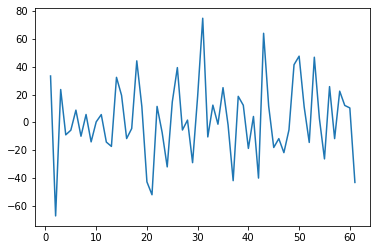

In [339]:
import matplotlib.pyplot as plt

reward_plot = [a for a in rewards if abs(a) < 5000 and a != 0]

x_rewards = [i + 1 for i in range(len(reward_plot))]

plt.plot(x_rewards, reward_plot)
plt.show()

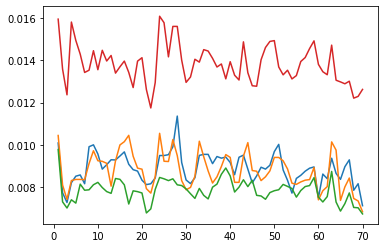

In [327]:
l1 = []
l2 = []
l3 = []
l4 = []
avg = []
j = 0
for i in range(len(all_states)):
    temp = float(all_states[i][9][17])
    if temp == 0.10000000149011612:
        continue
    if j == 70:
        break
    j += 1
    l1.append(temp)
    l2.append(float(all_states[i][9][18]))
    l3.append(float(all_states[i][9][19]))
    l4.append(float(all_states[i][9][20]))

x_l1 = [i + 1 for i in range(len(l1))]

plt.plot(x_l1, l1, label = "line 1")
plt.plot(x_l1, l2, label = "line 2")
plt.plot(x_l1, l3, label = "line 3")
plt.plot(x_l1, l4, label = "line 4")
plt.show()